In [1]:
# import require library
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass
import names
import json
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from matplotlib import pyplot as plt
import seaborn as sns
import eli5
from xml.dom import minidom
import os
from tqdm import tqdm
import pandas as pd
from xml.dom import minidom
import os
from tqdm import tqdm
import matplotlib.pyplot as plt 
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score
import numpy as np
from dowhy import CausalModel
from IPython.display import Image, display

In [2]:
# function that load medical information from MIMIC-III database
def load_medical_info(file_path):
    f = open(file_path,)
    medical_info_json = json.loads(json.load(f))
    f.close()
    
    data_abnormal_labevents = json.loads(medical_info_json['abnormal_labevents'])
    df_abnormal_labevents = pd.DataFrame.from_dict(data_abnormal_labevents)
    drugs = medical_info_json['drugs']
    diagnoses = medical_info_json['diagnoses_icd9_code']
    procedures = medical_info_json['procedures_icd9_code']
    
    return {'abnormal_labevents':df_abnormal_labevents, 
            'drugs':drugs,
            'diagnoses_icd9_code':diagnoses,
            'procedures_icd9_code':procedures}

# function that load demographic information from MIMIC-III database   
def load_demographic_info(file_path):
    f = open(file_path,)
    demographic_json = json.loads(json.load(f))
    f.close()
    return demographic_json

In [4]:
# define a path from which medical reports need to be extracted
import os 
my_list = os.listdir('/Users/kavanp/Documents/DoWhy/mimic3-pts-data-c94e8ff8-ee83-11eb-ab64-0242ac110003')
Dummy_List = my_list

In [5]:
# find ICD9 code for diabetes
import pandas as pd
df = pd.read_csv (r'/Users/kavanp/Documents/MIMIC III/diabetes_icd9_codes.csv')
original_diabites_icd9_code = df['icd9_code'].tolist()

In [7]:
# find the patient id who has diabites based on ICD9 code
from tqdm import tqdm
List_of_p_id_with_diabetes = []
for pid in tqdm(Dummy_List):
    if pid != '.DS_Store':
#         print(pid)
        patient_id = pid
        patient_dir = f'{data_dir}/{str(patient_id)}/'
        medical_info = load_medical_info(f'{patient_dir}/medical_info.json')
        icd9_code_present = medical_info['procedures_icd9_code']+medical_info['diagnoses_icd9_code']
#         print(icd9_code_present)
        check =  any(item in icd9_code_present for item in original_diabites_icd9_code)
        if check is True:
            List_of_p_id_with_diabetes.append(pid)

100%|██████████| 876/876 [00:03<00:00, 260.95it/s]


In [8]:
List_of_p_id_with_diabetes

['81849',
 '9693',
 '30668',
 '43969',
 '9804',
 '9464',
 '44377',
 '28807',
 '6478',
 '10464',
 '26905',
 '67967',
 '48342',
 '70188',
 '41052',
 '51006',
 '18469',
 '62647',
 '98365',
 '18655',
 '7505',
 '81074',
 '21784',
 '12109',
 '3765',
 '2688',
 '82036',
 '7900',
 '45009',
 '27198',
 '72956',
 '13162',
 '3070',
 '16486',
 '27597',
 '5547',
 '16678',
 '8204',
 '70099',
 '5386',
 '5988',
 '12045',
 '689',
 '31657',
 '13507',
 '13703',
 '87868',
 '53676',
 '61521',
 '80813',
 '22489',
 '32247',
 '58005',
 '25226',
 '28501',
 '31413',
 '9391',
 '90865',
 '261',
 '60422',
 '11618',
 '23716',
 '25888',
 '62926',
 '32800',
 '48276',
 '20931',
 '74229',
 '68676',
 '31040',
 '31244',
 '25889',
 '67032',
 '54479',
 '26865',
 '834',
 '40083',
 '11413',
 '66919',
 '5360',
 '95787',
 '4241',
 '13494',
 '28223',
 '13891',
 '31556',
 '6868',
 '76853',
 '28',
 '79427',
 '68131',
 '2694',
 '81608',
 '11701',
 '46057',
 '14873',
 '56458',
 '28857',
 '13686',
 '19714',
 '18099',
 '72819',
 '90755

In [74]:
# Find the patient id who do not have diabetes and prepare output variable based on it
List_of_p_id_Non_diabetes = []
for ids in tqdm(Dummy_List):
    check = ids in List_of_p_id_with_diabetes
    if check is True:
        Ext = 0
    else:
        List_of_p_id_Non_diabetes.append(ids)
        
List_of_p_id_with_diabetes_new = []
for pid in List_of_p_id_with_diabetes:
    if pid != '.DS_Store':
        List_of_p_id_with_diabetes_new.append(pid)

Outcome_0 = []
for pid in tqdm(List_of_p_id_with_diabetes_new):
    patient_id = pid
    patient_dir = f'{data_dir}/{str(patient_id)}/encounter/'
    demo_url = f'{data_dir}/{str(patient_id)}/'
    medical_info = load_medical_info(f'{demo_url}medical_info.json')
    for i in (list(medical_info['abnormal_labevents']['label'])):
              Outcome_0.append(i)       

100%|██████████| 876/876 [00:00<00:00, 195895.20it/s]


In [67]:
# Function that find out unique values from list
def unique(list1):
    x = np.array(list1)
    return list(np.unique(x))

In [68]:
# Find unique abnomal lab events fromn all diabetes patients 
Unique_Outcome = unique(Outcome_0)
Unique_Outcome = list(map(str, Unique_Outcome))
# Generate count for each abnormal lab events
Unique_value = []
for i in tqdm(Unique_Outcome):
    Unique_value.append(Outcome_0.count(i))

In [71]:
d = {'Tag':Unique_Outcome,'val':Unique_value}
df = pd.DataFrame(d)

In [72]:
# find top 5 abnormal lab events in diabetes 
df.sort_values(by='val', ascending=False).head()

,Tag,val
60,Hematocrit,4887
56,Glucose,4847
61,Hemoglobin,4727
123,Red Blood Cells,4302
145,Urea Nitrogen,3482


In [75]:
List_of_p_id_with_diabetes = List_of_p_id_with_diabetes[0:100]
List_of_p_id_Non_diabetes = List_of_p_id_Non_diabetes[0:100]

In [76]:
List_of_p_id_with_diabetes_new = []
for pid in List_of_p_id_with_diabetes:
    if pid != '.DS_Store':
        List_of_p_id_with_diabetes_new.append(pid)

In [77]:
List_of_p_id_Non_diabetes_new = []
for pid in List_of_p_id_Non_diabetes:
    if pid != '.DS_Store':
        List_of_p_id_Non_diabetes_new.append(pid)

In [153]:
# Find friquency of top 5 abnormal lab events in each Diabetes patient  
Report_0 = []
Outcome_0 = []
Age_0 = []
Insulin_0 = []
Glucose_0 = []
Hematocrit_0 = []
Hemoglobin_0 = []
RBC_0=[]
UN_0 = []
for pid in tqdm(List_of_p_id_with_diabetes_new):
    patient_id = pid
    patient_dir = f'{data_dir}/{str(patient_id)}/encounter/'
    demo_url = f'{data_dir}/{str(patient_id)}/'
    medical_info = load_medical_info(f'{demo_url}medical_info.json')
    k = medical_info['abnormal_labevents']
    if 'Glucose' in list(medical_info['abnormal_labevents']['label']):
#         l = sum((list(k.loc[k['label'] == 'Glucose']['valuenum']))) / len((list(k.loc[k['label'] == 'Glucose']['valuenum'])))
        l = len(k.loc[k['label'] == 'Glucose'].index)
        Glucose_0.append(l)
    else:
        Glucose_0.append(0)    
            
    if 'Hematocrit' in list(medical_info['abnormal_labevents']['label']):
#         l = sum((list(k.loc[k['label'] == 'Hematocrit']['valuenum']))) / len((list(k.loc[k['label'] == 'Hematocrit']['valuenum'])))
        l = len(k.loc[k['label'] == 'Hematocrit'].index)
        Hematocrit_0.append(l)
    else:
        Hematocrit_0.append(0)   
    
    if 'Hemoglobin' in list(medical_info['abnormal_labevents']['label']):
#         l = sum((list(k.loc[k['label'] == 'Hemoglobin']['valuenum']))) / len((list(k.loc[k['label'] == 'Hemoglobin']['valuenum'])))
        l = len(k.loc[k['label'] == 'Hemoglobin'].index)
        Hemoglobin_0.append(l)
    else:
        Hemoglobin_0.append(0) 
        
    if 'Red Blood Cells' in list(medical_info['abnormal_labevents']['label']):
#         l = sum((list(k.loc[k['label'] == 'Red Blood Cells']['valuenum']))) / len((list(k.loc[k['label'] == 'Red Blood Cells']['valuenum'])))
        l = len(k.loc[k['label'] == 'Red Blood Cells'].index)
        RBC_0.append(l)
    else:
        RBC_0.append(0) 

    if 'Urea Nitrogen' in list(medical_info['abnormal_labevents']['label']):
#         l = sum((list(k.loc[k['label'] == 'Urea Nitrogen']['valuenum']))) / len((list(k.loc[k['label'] == 'Urea Nitrogen']['valuenum'])))
        l = len(k.loc[k['label'] == 'Urea Nitrogen'].index)
        UN_0.append(l)
    else:
        UN_0.append(0) 
    
    Report = "Report:"
    demographic_json = load_demographic_info(f'{demo_url}demographic.json')
    Age_0.append(list(demographic_json.values())[0])
    for file in os.listdir(patient_dir):
        if file.endswith(".txt"):
            f = open(os.path.join(patient_dir, file), "r")
            Report = Report + " " + (f.read())
    Report_0.append(Report)
    Outcome_0.append(1)

100%|██████████| 100/100 [00:00<00:00, 106.99it/s]


In [155]:
# Find friquency of top 5 abnormal lab events in each non Diabetes patient 
Report_1 = []
Outcome_1 = []
Age_1 = []
Insulin_1 = []
Glucose_1 = []
Hematocrit_1 = []
Hemoglobin_1 = []
RBC_1 =[]
UN_1 = []
for pid in tqdm(List_of_p_id_Non_diabetes_new):
    patient_id = pid
    patient_dir = f'{data_dir}/{str(patient_id)}/encounter/'
    demo_url = f'{data_dir}/{str(patient_id)}/'
    Report = "Report:"
    
    medical_info = load_medical_info(f'{demo_url}medical_info.json')
    k = medical_info['abnormal_labevents']
    if 'Glucose' in list(medical_info['abnormal_labevents']['label']):
#         l = sum((list(k.loc[k['label'] == 'Glucose']['valuenum']))) / len((list(k.loc[k['label'] == 'Glucose']['valuenum'])))
        l = len(k.loc[k['label'] == 'Glucose'].index)
        Glucose_1.append(l)
    else:
        Glucose_1.append(0)    
            
    if 'Hematocrit' in list(medical_info['abnormal_labevents']['label']):
#         l = sum((list(k.loc[k['label'] == 'Hematocrit']['valuenum']))) / len((list(k.loc[k['label'] == 'Hematocrit']['valuenum'])))
        l = len(k.loc[k['label'] == 'Hematocrit'].index)
        Hematocrit_1.append(l)
    else:
        Hematocrit_1.append(0)   
    
    if 'Hemoglobin' in list(medical_info['abnormal_labevents']['label']):
#         l = sum((list(k.loc[k['label'] == 'Hemoglobin']['valuenum']))) / len((list(k.loc[k['label'] == 'Hemoglobin']['valuenum'])))
        l = len(k.loc[k['label'] == 'Hemoglobin'].index)
        Hemoglobin_1.append(l)
    else:
        Hemoglobin_1.append(0) 
        
    if 'Red Blood Cells' in list(medical_info['abnormal_labevents']['label']):
#         l = sum((list(k.loc[k['label'] == 'Red Blood Cells']['valuenum']))) / len((list(k.loc[k['label'] == 'Red Blood Cells']['valuenum'])))
        l = len(k.loc[k['label'] == 'Red Blood Cells'].index)
        RBC_1.append(l)
    else:
        RBC_1.append(0) 

    if 'Urea Nitrogen' in list(medical_info['abnormal_labevents']['label']):
#         l = sum((list(k.loc[k['label'] == 'Urea Nitrogen']['valuenum']))) / len((list(k.loc[k['label'] == 'Urea Nitrogen']['valuenum'])))
        l = len(k.loc[k['label'] == 'Urea Nitrogen'].index)
        UN_1.append(l)
    else:
        UN_1.append(0)  
    
    demographic_json = load_demographic_info(f'{demo_url}demographic.json')
    Age_1.append(list(demographic_json.values())[0])
    for file in os.listdir(patient_dir):
        if file.endswith(".txt"):
            f = open(os.path.join(patient_dir, file), "r")
            Report = Report + " " + (f.read())
    Report_1.append(Report)
    Outcome_1.append(0)

100%|██████████| 99/99 [00:00<00:00, 179.09it/s]


In [156]:
# Dataframe containing abnormal lab events information for each Diabetes patient 
d = {'Outcome':Outcome_0,'Gender':Age_0,'Glucose':Glucose_0,'Hematocrit':Hematocrit_0,'Hemoglobin':Hemoglobin_0,'RBC':RBC_0,'UN':UN_0}
import pandas as pd
MIMIC_01 = pd.DataFrame(d)

In [157]:
MIMIC_01

,Outcome,Gender,Glucose,Hematocrit,Hemoglobin,RBC,UN
0,1,F,9,7,7,7,8
1,1,M,6,6,6,6,1
2,1,F,14,21,20,20,20
3,1,F,3,7,6,5,0
4,1,F,5,26,19,16,8
...,...,...,...,...,...,...,...
95,1,F,88,77,80,80,82
96,1,M,13,5,9,6,1
97,1,M,19,19,22,22,5
98,1,M,20,41,37,36,37


In [158]:
# generate index value
ind = []
for i in range(99):
    ind.append(100+i)

In [159]:
# Dataframe containing abnormal lab events information for each non Diabetes patient 
d = {'Outcome':Outcome_1,'Gender':Age_1,'Glucose':Glucose_1,'Hematocrit':Hematocrit_1,'Hemoglobin':Hemoglobin_1,'RBC':RBC_1,'UN':UN_1,'ind':ind}
import pandas as pd
MIMIC_02 = pd.DataFrame(d)
MIMIC_02 = MIMIC_02.set_index('ind')

In [160]:
# merge both dataframe
MIMIC_Dataset = MIMIC_01.append(MIMIC_02)

In [161]:
MIMIC_Dataset

,Outcome,Gender,Glucose,Hematocrit,Hemoglobin,RBC,UN
0,1,F,9,7,7,7,8
1,1,M,6,6,6,6,1
2,1,F,14,21,20,20,20
3,1,F,3,7,6,5,0
4,1,F,5,26,19,16,8
...,...,...,...,...,...,...,...
194,0,M,4,12,6,6,5
195,0,F,2,1,2,0,6
196,0,F,21,8,9,21,1
197,0,M,40,28,34,30,29


In [168]:
MIMIC_Dataset.to_csv(r'/Users/kavanp/Downloads/dt.csv')

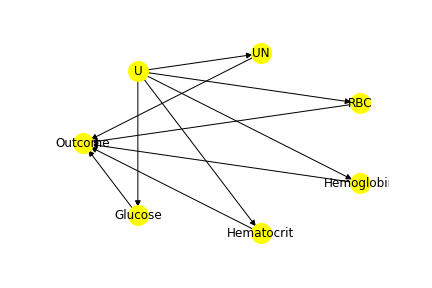

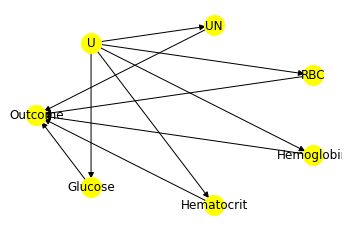

In [107]:
# Create casual inferance graph
causal_graph = """
digraph {
Outcome;
Glucose;
Hematocrit;
Hemoglobin;
RBC;
UN;
U[label="Unobserved Confounders"];
Glucose -> Outcome;
Hematocrit -> Outcome;
Hemoglobin -> Outcome;
RBC -> Outcome;
UN -> Outcome;
U->Glucose; U-> Hematocrit; U->Hemoglobin; U->RBC; U->UN;
}
"""

model= CausalModel(
        data = training,
        graph=causal_graph.replace("\n", " "),
        treatment=['Glucose','Hematocrit','Hemoglobin','RBC','UN'],
        outcome='Outcome')
model.view_model()
display(Image(filename="causal_model.png"))

In [108]:
# find various way to find casual estimation 
estimands = model.identify_effect()
print(estimands)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
                     d                                           
───────────────────────────────────────────(Expectation(Outcome))
d[Glucose  Hematocrit  Hemoglobin  RBC  UN]                      
Estimand assumption 1, Unconfoundedness: If U→{Glucose,Hematocrit,Hemoglobin,RBC,UN} and U→Outcome then P(Outcome|Glucose,Hematocrit,Hemoglobin,RBC,UN,,U) = P(Outcome|Glucose,Hematocrit,Hemoglobin,RBC,UN,)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(Outcome, [U])*Derivative([Glucose, Hematocrit, Hemoglob
in, RBC, UN], [U])**(-1))
Estimand assumption 1, As-if-random: If U→→Outcome then ¬(U →→{U})
Estimand assumption 2, Exclusion: If we remove {U}→{Glucose,Hematocrit,Hemoglobin,RBC,UN}, then ¬({U}→Outcome)

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [109]:
# find casual effect using linear regression 
estimate = model.estimate_effect(estimands,method_name = "backdoor.linear_regression")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
                     d                                           
───────────────────────────────────────────(Expectation(Outcome))
d[Glucose  Hematocrit  Hemoglobin  RBC  UN]                      
Estimand assumption 1, Unconfoundedness: If U→{Glucose,Hematocrit,Hemoglobin,RBC,UN} and U→Outcome then P(Outcome|Glucose,Hematocrit,Hemoglobin,RBC,UN,,U) = P(Outcome|Glucose,Hematocrit,Hemoglobin,RBC,UN,)

## Realized estimand
b: Outcome~Glucose+Hematocrit+Hemoglobin+RBC+UN
Target units: ate

## Estimate
Mean value: 0.5064208583738327



In [96]:
# evaluate this casual effect using random common cause
refutel = model.refute_estimate(estimands,estimate, "random_common_cause")
print(refutel)

Refute: Add a Random Common Cause
Estimated effect:0.006905525233744686
New effect:0.004151703132078716

